<a href="https://colab.research.google.com/github/junhyeokk/boomhill24/blob/main/data/kart-data-processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import math
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

In [3]:
def is_pushed(img):
    """
    인식 오류 있을 경우 np.sum과 비교하는 기준값 또는 아래 key_size 조절 필요
    """ 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    return 1 if np.sum(thr) > 200 else 0

In [4]:
# video 파일 이름
vidname = "20210401_070930PM"
# 카트가 사용하는 엔진 입력
enginetype = 'x'
# 아이템 슬롯 갯수
boost_slot_size = 3
# 영상 순번
vid_num = 0
# 키뷰어 크기
key_viewer_size = (349,180)

In [5]:
# 저장 path 설정
drivepath = "/content/gdrive/MyDrive/kart/"
capdir1 = f"{vidname}_{vid_num:02d}_screen/"       # 이미지 저장 directory 이름
capdir2 = f"{vidname}_{vid_num:02d}_minimap/"
csvname = f"{vidname}_{vid_num:02d}.csv"   # csv 파일 이름
cappath1 = os.path.join(drivepath, capdir1)  # 이미지 저장 경로
cappath2 = os.path.join(drivepath, capdir2)
csvpath = os.path.join(drivepath, "csv/")    # csv 파일 경로
vidpath = os.path.join('/content/gdrive/Shareddrives/umapyoi/', vidname + ".mp4")
itempath = os.path.join(drivepath,"boostimg/")
# 저장된 계기판 숫자 예시 이미지 로드
# x 엔진 : /xnum/  v1 엔진 : /v1num/
numpath = os.path.join(drivepath,enginetype+'num/')
# directory 없을 시 생성
rankImgsPath = os.path.join(drivepath,'rankNum/')

if not os.path.exists(cappath1):
  os.makedirs(cappath1)

if not os.path.exists(cappath2):
  os.makedirs(cappath2)

if not os.path.exists(csvpath):
  os.makedirs(csvpath)

In [6]:
# csv 파일 생성, 비디오 파일 open
cap = cv2.VideoCapture(vidpath)
fcsv = open(os.path.join(csvpath+csvname),'w',encoding='utf-8')
wrcsv = csv.writer(fcsv)
print(vidpath)

/content/gdrive/Shareddrives/umapyoi/20210401_070930PM.mp4


In [7]:
print(capdir1)

20210401_070930PM_00_screen/


In [8]:
key_viewer_size

(349, 180)

각 image 위치


In [9]:
shift_pos = (33.0/349.0*key_viewer_size[0],30.0/180.0*key_viewer_size[1])
ctrl_pos = (33.0/349.0*key_viewer_size[0],102.0/180.0*key_viewer_size[1])
left_pos = (120.0/349.0*key_viewer_size[0],102.0/180.0*key_viewer_size[1])
down_pos = (192.0/349.0*key_viewer_size[0],102.0/180.0*key_viewer_size[1])
right_pos = (262.0/349.0*key_viewer_size[0],102.0/180.0*key_viewer_size[1])
up_pos = (192.0/349.0*key_viewer_size[0],33.0/180.0*key_viewer_size[1])

key_viewer_top_left = (1440-key_viewer_size[0],1080-key_viewer_size[1])

key_pos = [
           (round(key_viewer_top_left[0]+up_pos[0]),
            round(key_viewer_top_left[1]+up_pos[1])),
           
           (round(key_viewer_top_left[0]+left_pos[0]),
            round(key_viewer_top_left[1]+left_pos[1])),
           
           (round(key_viewer_top_left[0]+right_pos[0]),
            round(key_viewer_top_left[1]+right_pos[1])),
           
           (round(key_viewer_top_left[0]+ctrl_pos[0]),
            round(key_viewer_top_left[1]+ctrl_pos[1])),
           
           (round(key_viewer_top_left[0]+shift_pos[0]),
            round(key_viewer_top_left[1]+shift_pos[1])),
           
           (round(key_viewer_top_left[0]+down_pos[0]),
            round(key_viewer_top_left[1]+down_pos[1])),
]

# 키 인식 이미지 크기
key_size = 15

# 계기판 숫자 위치 (V1 엔진 or X 엔진)
# 3자리 일 경우
if enginetype == 'v1':
  gauge100pos = [649,965]
  gauge010pos = [697,965]
  gauge001pos = [745,965]
  # 2자리 일 경우
  gauge10pos = [673,965]
  gauge01pos = [721,965]
  gauge_w = 48; gauge_h = 56
if enginetype == 'x':
  gauge100pos = [672,982]
  gauge010pos = [703,982]
  gauge001pos = [734,982]
  # 2자리 일 경우
  gauge10pos = [688,982]
  gauge01pos = [719,982]
  gauge_w = 31; gauge_h = 56

# 등수 숫자 위치
rankPos = [28, 242]
rankW = 84
rankH = 74

# 전체 인원 숫자 위치
totalRankPos = [143, 282]
totalRankW = 22
totalRankH = 31


prevpath = ""
prevminimap = ""
prevspeed = 0
prevboost = False
prevdraft = False
prevboost_percent = 0
previtem = 0
prevrank = 8


이미지 로드

In [10]:
gauge = []

for i in np.arange(10):
  gaugepath = os.path.join(numpath + f'/num{i}.png')
  gaugenum = cv2.imread(gaugepath, cv2.IMREAD_GRAYSCALE)
  _, num_thresh = cv2.threshold(gaugenum, 135, 255, cv2.THRESH_BINARY)
  gauge.append(num_thresh)

rankImgs = []

for i in np.arange(1, 9):
  rankImgPath = os.path.join(rankImgsPath + f'/num{i}.png')
  rankNum = cv2.imread(rankImgPath, cv2.IMREAD_GRAYSCALE)
  _, num_thresh = cv2.threshold(rankNum, 200, 255, cv2.THRESH_BINARY)
  rankImgs.append(num_thresh)

In [11]:
# 숫자 이미지를 예시 이미지와 매칭
def gauge_match(numimg):
  _, img_thresh = cv2.threshold(numimg, 135, 255, cv2.THRESH_BINARY)
  for i, num in enumerate(gauge):
    diff = cv2.bitwise_xor(img_thresh,num)
    diffcount = cv2.countNonZero(diff)
    #plt.subplot(2,5,i+1)
    #plt.imshow(diff,cmap='gray')
    if diffcount < 200:
      #plt.show()
      #print(f'{i}th diff is {diffcount}')
      return i
  # 매칭하는 이미지가 없다면 0
  #plt.show()
  return 0

In [12]:
def gauge_speed(frame):
  # 현재 계기판 이미지 자리별 추출 (자리가 매치하지 않으면 0로 계산)
  gaugeimg_100 = cv2.cvtColor(frame[gauge100pos[1]:gauge100pos[1]+gauge_h,
                                    gauge100pos[0]:gauge100pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  gaugeimg_010 = cv2.cvtColor(frame[gauge010pos[1]:gauge010pos[1]+gauge_h,
                                    gauge010pos[0]:gauge010pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  gaugeimg_001 = cv2.cvtColor(frame[gauge001pos[1]:gauge001pos[1]+gauge_h,
                                    gauge001pos[0]:gauge001pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)  
  gaugeimg_10 = cv2.cvtColor(frame[gauge10pos[1]:gauge10pos[1]+gauge_h,
                                   gauge10pos[0]:gauge10pos[0]+gauge_w],
                             cv2.COLOR_BGR2GRAY)
  gaugeimg_01 = cv2.cvtColor(frame[gauge01pos[1]:gauge01pos[1]+gauge_h,
                                   gauge01pos[0]:gauge01pos[0]+gauge_w],
                              cv2.COLOR_BGR2GRAY)
  speed_100 = gauge_match(gaugeimg_100)
  speed_010 = gauge_match(gaugeimg_010)
  speed_001 = gauge_match(gaugeimg_001)
  speed_10 = gauge_match(gaugeimg_10)
  speed_01 = gauge_match(gaugeimg_01)

  
  # 자리가 매치하지 않으면 0으로 계산됨(무시됨)    
  return speed_100*100 + speed_010*10 + speed_001 + speed_10*10 + speed_01

In [13]:
def boost_v1(frame:np.ndarray)->bool:
    """
    v1 엔진의 부스터가 켜져있으면 True 꺼져있으면 False를 return함
    """
    # 특정 5x5 범위 픽셀의 HSV 평균을 구함 (해당 픽셀이 매우 밝은 주황에 가까울 경우)
    # H 값이 25 이하 (색이 빨강~주황에 가까울 때)
    # V 값이 230 이상 (밝기가 매우 밝을 때)
    hsv = cv2.cvtColor(frame[1045:1050,598:603], cv2.COLOR_BGR2HSV)
    return True if np.average(hsv[:,:,2]) > 230 and np.average(hsv[:,:,0]) < 25 else False

In [14]:
def draft_v1(frame:np.ndarray)->bool:
    """
    v1 엔진의 드래프트가 켜져있으면 True 꺼져있으면 False를 return함
    """
    # 특정 5x5 범위 픽셀의 HSV 평균을 구함 (해당 픽셀이 매우 밝은 연두에 가까울 경우)
    # H 값이 40 근처 (색이 연두에 가까울 때)
    # V 값이 230 이상 (밝기가 매우 밝을 때)
    hsv = cv2.cvtColor(frame[1045:1050,841:846], cv2.COLOR_BGR2HSV)
    return True if np.average(hsv[:,:,2]) > 230 and 35 < np.average(hsv[:,:,0]) < 50 else False

In [15]:
def boost_range(frame:np.ndarray)->float:
    """
    부스터의 게이지를 0~1 까지 0.1 단위로 측정하여 출력
    """
    for per in np.arange(0,1,0.1):
        #print(f"{per} percent image")
        percent_pos = circle_position((721,1019),100, per)
        boost_pos = frame[percent_pos[1]-2:percent_pos[1]+2,percent_pos[0]-2:percent_pos[0]+2]
        #print(f"{per} : {percent_pos}")
        #cv2_imshow(boost_pos)
        if np.average(boost_pos[:,:,2]) < 100 :
            return per
    
    return 1

In [16]:
def circle_position(middle:tuple, radius:float, percent:float)->tuple:
    """
    픽셀 값의 위치를 percent 별로 설정
    """
    angle = 1.04*math.pi + percent*math.pi*1.06
    x = int(middle[0] + radius*math.cos(angle))
    y = int(middle[1] + radius*math.sin(angle))
    return (x,y)

In [17]:
def load_boost(imgpath:str)->list:
    """
    각 기본 부스터 큰 이미지, 작은 이미지, 팀 부스터 큰 이미지, 작은 이미지 순서로 된 이미지 list를 return
    Grayscale 이미지로 로드함
    """
    boost_big_normal = cv2.imread(os.path.join(imgpath,"normal_1_img.jpg"), cv2.IMREAD_GRAYSCALE)
    boost_small_normal = cv2.imread(os.path.join(imgpath,"normal_3_img.jpg"), cv2.IMREAD_GRAYSCALE)
    boost_big_team = cv2.imread(os.path.join(imgpath,"team_1_img.jpg"), cv2.IMREAD_GRAYSCALE)
    boost_small_team = cv2.imread(os.path.join(imgpath,"team_3_img.jpg"), cv2.IMREAD_GRAYSCALE)

    return [boost_big_normal,boost_small_normal,boost_big_team,boost_small_team]

In [18]:
def check_boost(img_list:list,frame:np.ndarray, boost_slot_cnt:int = 3)->list:
    """
    로드된 부스터 이미지와 비교하여 부스터 여부를 체크함
    좌측 부스터 슬롯 부터
    팀 부스터일 경우 1, 기본 부스터일 경우 2, 부스터가 없을 경우 0
    """
    if boost_slot_cnt != 2 and boost_slot_cnt != 3:
        raise ValueError('Wrong Number of Boost Slot!')
    img_rgb = frame[0:150,0:350].copy()
    img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)

    img_3_boost = img_gray[15:115,223:323]
    img_2_boost = img_gray[15:92,133:210] if boost_slot_cnt == 3 else img_gray[15:115,133:233]
    img_1_boost = img_gray[15:92,43:120]
    
    normal_score_list = [0,0,0] if boost_slot_cnt == 3 else [0,0]
    team_score_list = [0,0,0] if boost_slot_cnt == 3 else [0,0]

    # 1번째 자리 기본 부스터 스코어
    normal_score_list[0],_ = match_two_image(img_list[1],img_1_boost)
        
    # 1번째 자리 팀 부스터 스코어
    team_score_list[0],_ = match_two_image(img_list[3],img_1_boost)
   
    # 2번째 자리 기본 부스터 스코어
    normal_score_list[1],_ = match_two_image(img_list[1] if boost_slot_cnt == 3 else img_list[0],img_2_boost)
    
    # 2번째 자리 팀 부스터 스코어
    team_score_list[1],_ = match_two_image(img_list[3] if boost_slot_cnt == 3 else img_list[2],img_2_boost)
    
    if boost_slot_cnt == 3:
        # 3번째 자리 기본 부스터 스코어
        normal_score_list[2],_ = match_two_image(img_list[0],img_3_boost)
        
        # 3번째 자리 팀 부스터 스코어
        team_score_list[2],_ = match_two_image(img_list[2],img_3_boost)

    result = list()

    for n_score, t_score in zip(normal_score_list,team_score_list):
        if n_score > 0.75 or t_score > 0.75:
            if n_score > t_score:
                result.append(2)
            else:
                result.append(1)
        else:
            result.append(0)

    return result

In [19]:
def match_two_image(template_img:np.ndarray, img:np.ndarray)->tuple:
    """
    template image와 다른 image를 match 하여 가장 match 가능성이 높은 위치와 match score를 return
    """
    res = cv2.matchTemplate(img,template_img,cv2.TM_CCOEFF_NORMED)
    _, maxVal, _, maxLoc = cv2.minMaxLoc(res)

    return maxVal, maxLoc

아래는 등수 추출 관련 함수

In [20]:
# 순위를 예시 이미지와 매칭
def rank_match(numimg):
  _, img_thresh = cv2.threshold(numimg, 200, 255, cv2.THRESH_BINARY)
  #cv2_imshow(numimg)
  for i, num in enumerate(rankImgs):
    diff = cv2.bitwise_xor(img_thresh,num)
    diffcount = cv2.countNonZero(diff)
    if diffcount < 500:
      #print(f'{i+1}th diff is {diffcount}')
      return i+1
  # 매칭하는 이미지가 없다면 0
  #print("NOT MATCHED")
  return 0

# 숫자 따기
def getRank(frame):
  rankImg = cv2.cvtColor(frame[rankPos[1]:rankPos[1]+rankH,
                               rankPos[0]:rankPos[0]+rankW],
                               cv2.COLOR_BGR2GRAY)
  rank = rank_match(rankImg)
  return rank

In [21]:
boost_img_list = load_boost(itempath)

영상 추출 관련 기본 데이터

In [22]:
fps = round(cap.get(cv2.CAP_PROP_FPS))
start_sec = 746        # Start time
end_sec = 767         # End time
interval = 0.1          # Time interval
# 단위는 초

print(f"fps : {fps}")

fps : 60


  0%|          | 0/210 [00:00<?, ?it/s]

key string at 746.0 is 000000


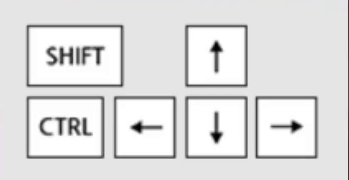

key string at 746.1 is 000000


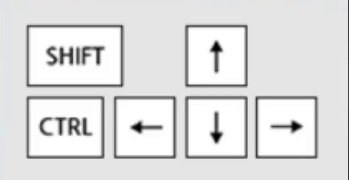

key string at 746.2 is 000000


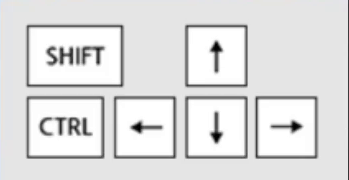

key string at 746.3000000000001 is 000000


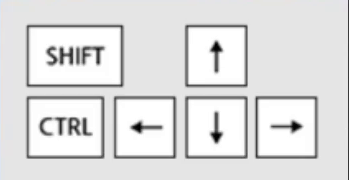

key string at 746.4000000000001 is 000000


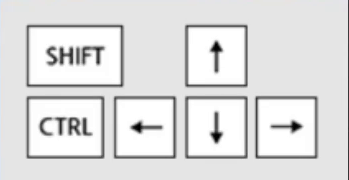

key string at 746.5000000000001 is 000000


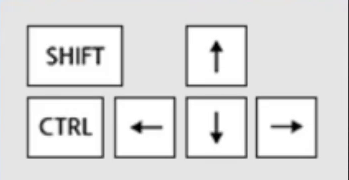

key string at 746.6000000000001 is 000000


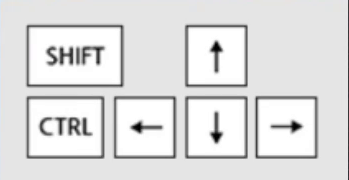

key string at 746.7000000000002 is 000000


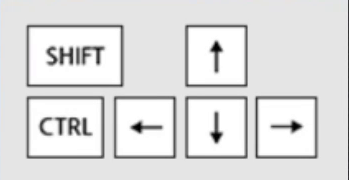

key string at 746.8000000000002 is 000000


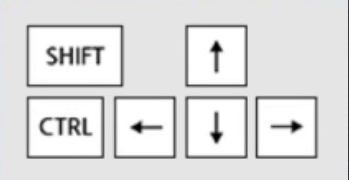

key string at 746.9000000000002 is 000000


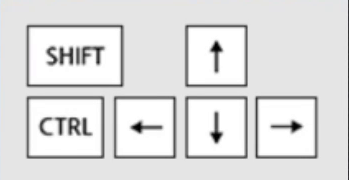

key string at 747.0000000000002 is 000000


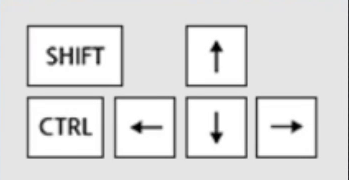

key string at 747.1000000000003 is 000000


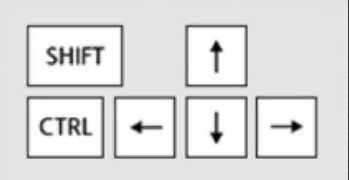

key string at 747.2000000000003 is 000000


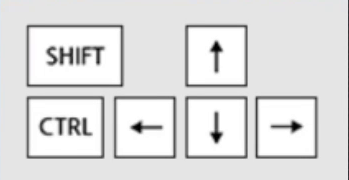

key string at 747.3000000000003 is 000000


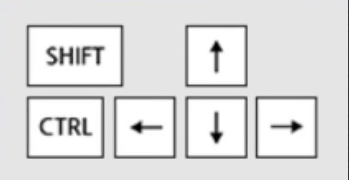

key string at 747.4000000000003 is 000000


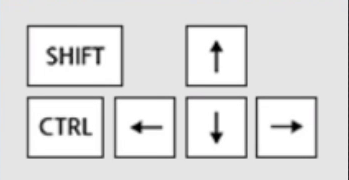

key string at 747.5000000000003 is 000000


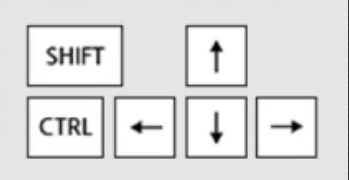

key string at 747.6000000000004 is 000000


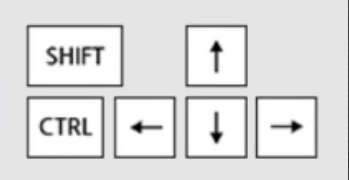

key string at 747.7000000000004 is 000000


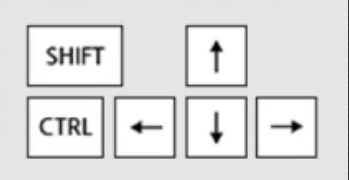

key string at 747.8000000000004 is 000000


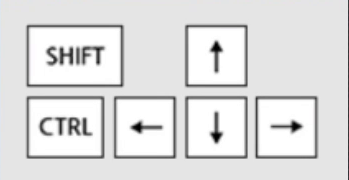

key string at 747.9000000000004 is 000000


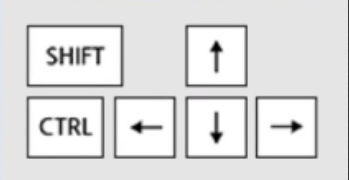

key string at 748.0000000000005 is 000000


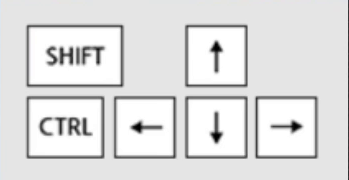

key string at 748.1000000000005 is 000000


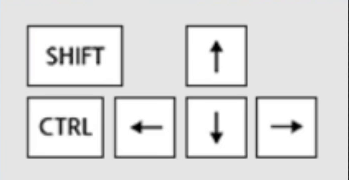

key string at 748.2000000000005 is 000000


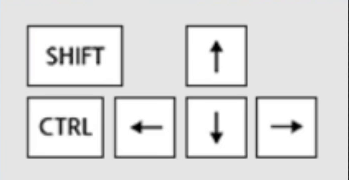

key string at 748.3000000000005 is 000000


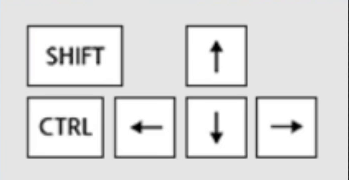

key string at 748.4000000000005 is 000000


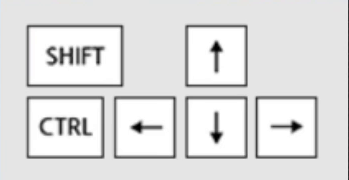

key string at 748.5000000000006 is 000000


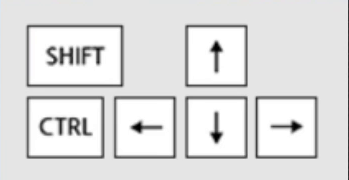

key string at 748.6000000000006 is 000000


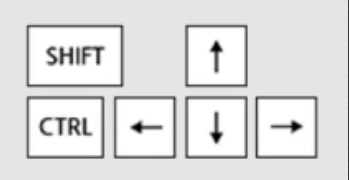

key string at 748.7000000000006 is 000000


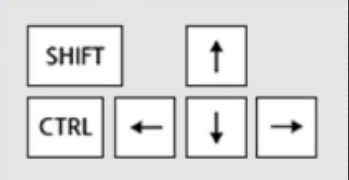

key string at 748.8000000000006 is 001000


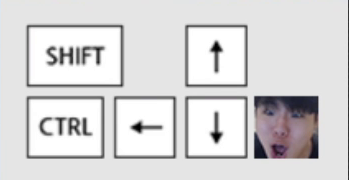

key string at 748.9000000000007 is 001000


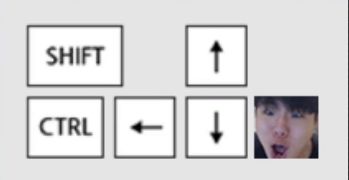

key string at 749.0000000000007 is 001000


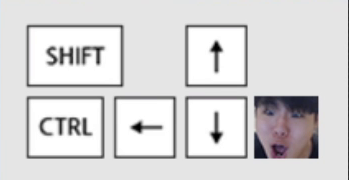

key string at 749.1000000000007 is 100000


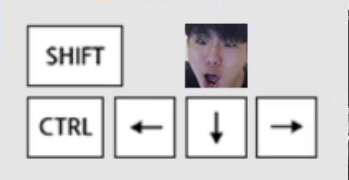

key string at 749.2000000000007 is 100000


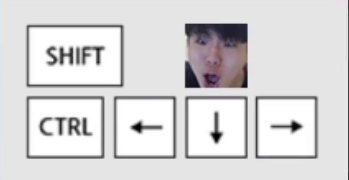

key string at 749.3000000000008 is 100000


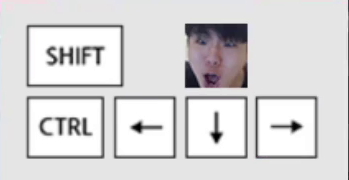

key string at 749.4000000000008 is 100000


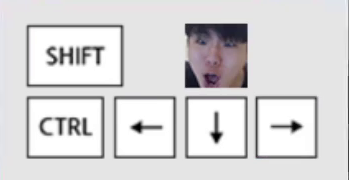

key string at 749.5000000000008 is 100000


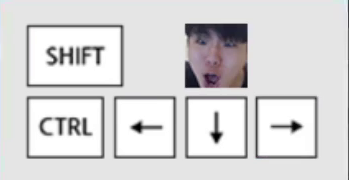

key string at 749.6000000000008 is 100000


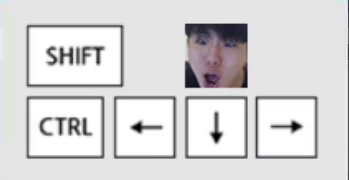

key string at 749.7000000000008 is 100000


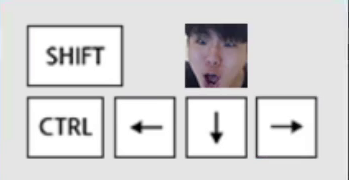

key string at 749.8000000000009 is 100000


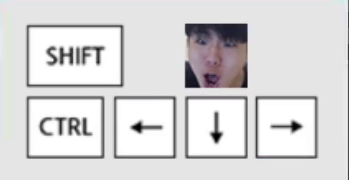

key string at 749.9000000000009 is 100000


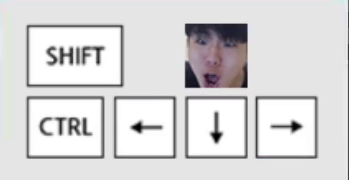

key string at 750.0000000000009 is 100000


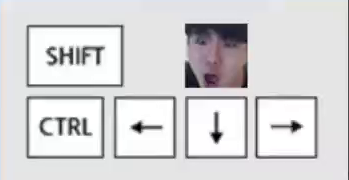

key string at 750.1000000000009 is 101000


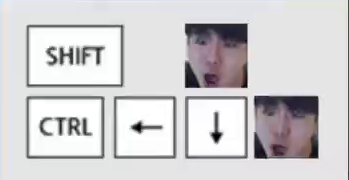

key string at 750.200000000001 is 101000


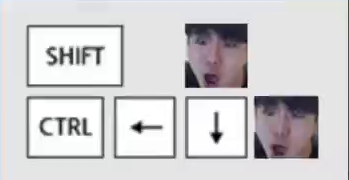

key string at 750.300000000001 is 101000


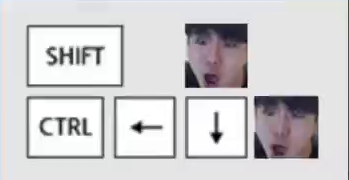

key string at 750.400000000001 is 101000


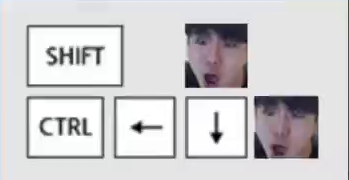

key string at 750.500000000001 is 101000


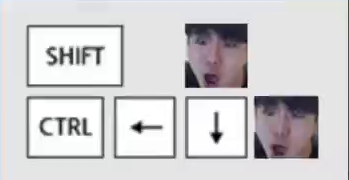

key string at 750.600000000001 is 101010


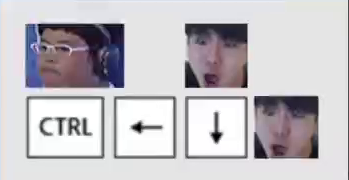

key string at 750.7000000000011 is 101010


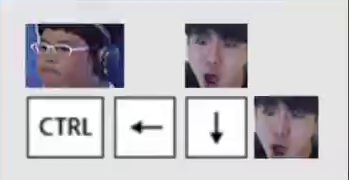

key string at 750.8000000000011 is 101010


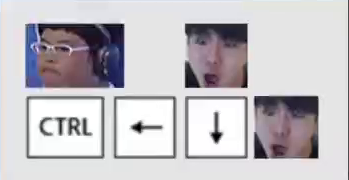

key string at 750.9000000000011 is 101010


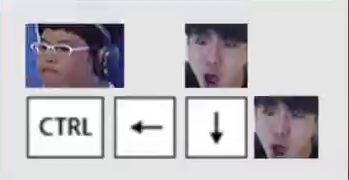

key string at 751.0000000000011 is 101010


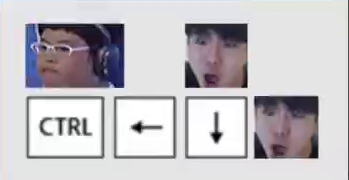

key string at 751.1000000000012 is 101000


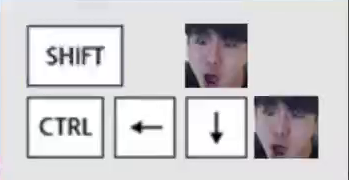

key string at 751.2000000000012 is 100000


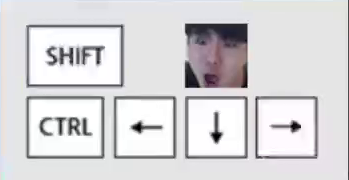

key string at 751.3000000000012 is 101000


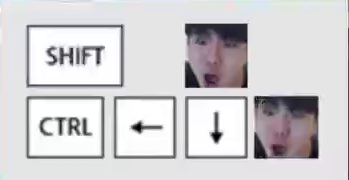

key string at 751.4000000000012 is 101000


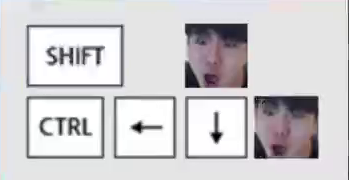

key string at 751.5000000000013 is 101000


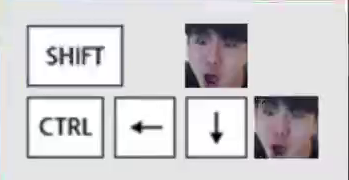

key string at 751.6000000000013 is 110000


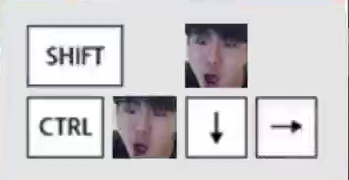

key string at 751.7000000000013 is 110000


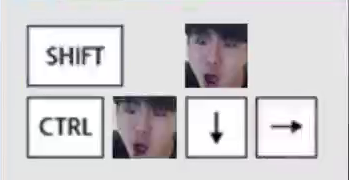

key string at 751.8000000000013 is 110000


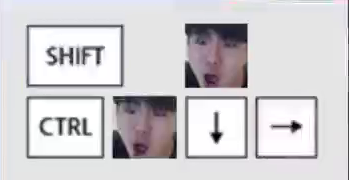

key string at 751.9000000000013 is 110000


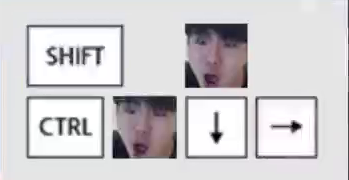

key string at 752.0000000000014 is 110000


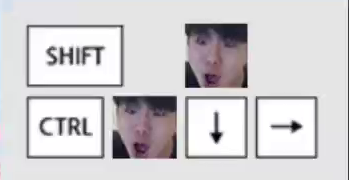

key string at 752.1000000000014 is 110000


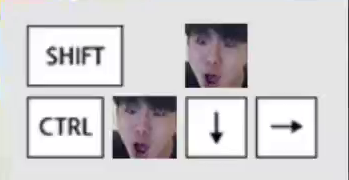

key string at 752.2000000000014 is 110000


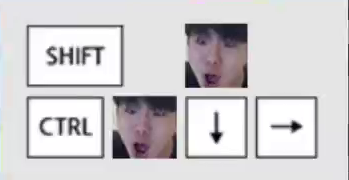

key string at 752.3000000000014 is 100000


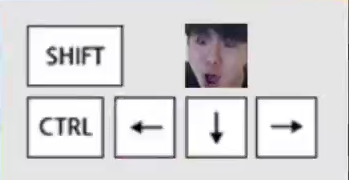

key string at 752.4000000000015 is 100000


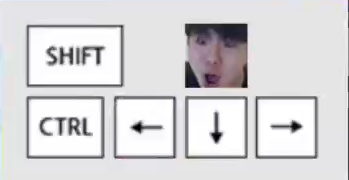

key string at 752.5000000000015 is 100000


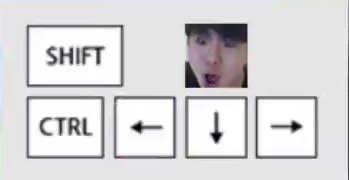

key string at 752.6000000000015 is 100000


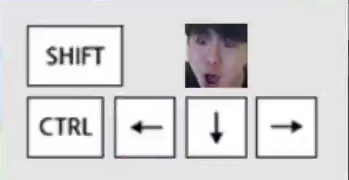

key string at 752.7000000000015 is 110000


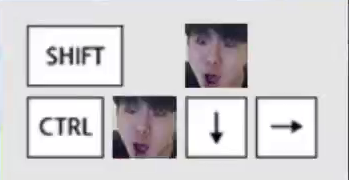

key string at 752.8000000000015 is 110000


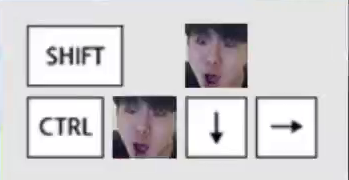

key string at 752.9000000000016 is 110000


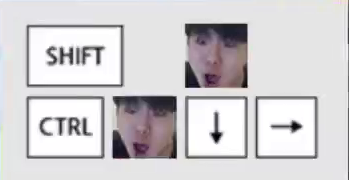

key string at 753.0000000000016 is 110000


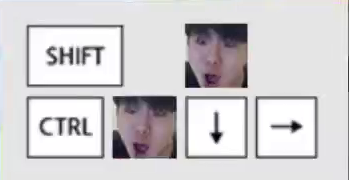

key string at 753.1000000000016 is 110000


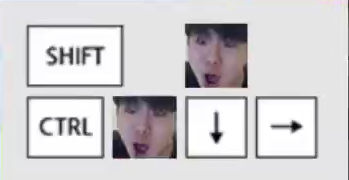

key string at 753.2000000000016 is 110000


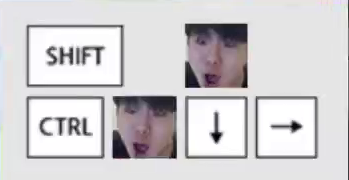

key string at 753.3000000000017 is 110010


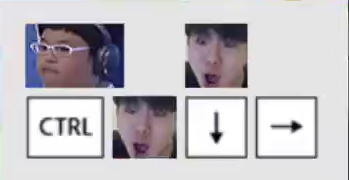

key string at 753.4000000000017 is 110010


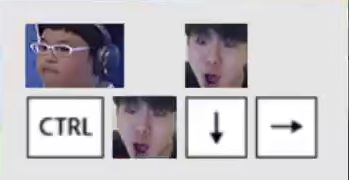

key string at 753.5000000000017 is 110010


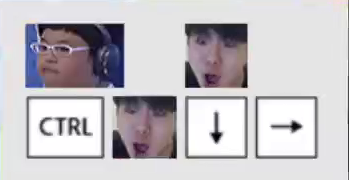

key string at 753.6000000000017 is 110010


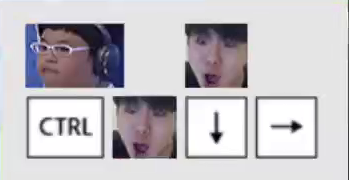

key string at 753.7000000000018 is 110010


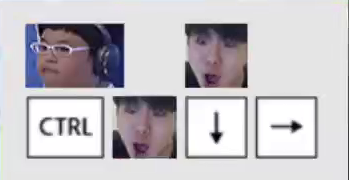

key string at 753.8000000000018 is 110010


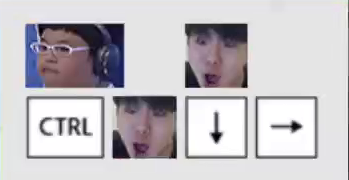

key string at 753.9000000000018 is 110010


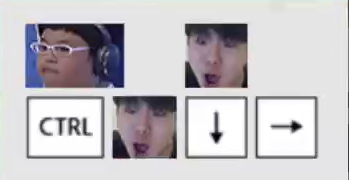

key string at 754.0000000000018 is 110010


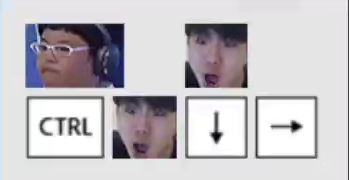

key string at 754.1000000000018 is 110000


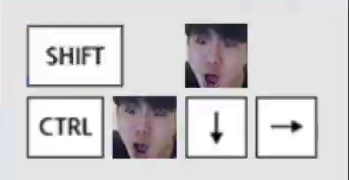

key string at 754.2000000000019 is 101000


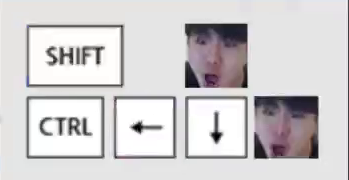

key string at 754.3000000000019 is 101000


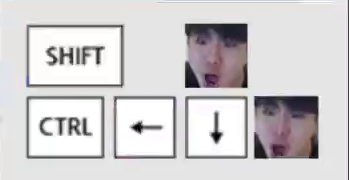

key string at 754.4000000000019 is 101000


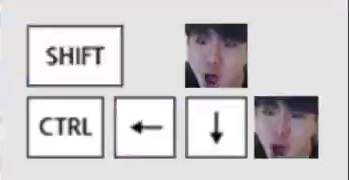

key string at 754.5000000000019 is 101000


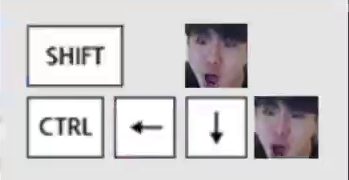

key string at 754.600000000002 is 101000


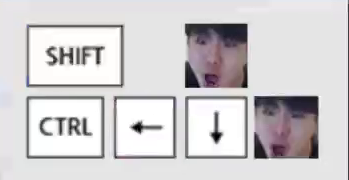

key string at 754.700000000002 is 101000


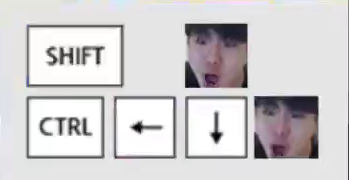

key string at 754.800000000002 is 101000


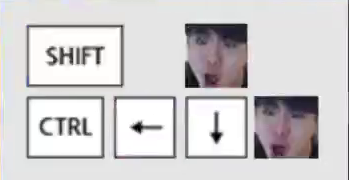

key string at 754.900000000002 is 111000


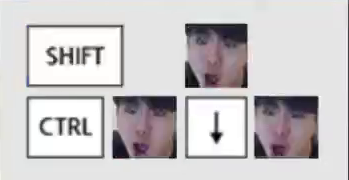

key string at 755.000000000002 is 110000


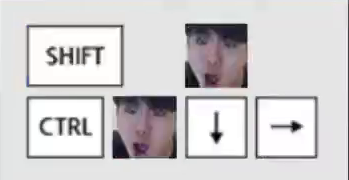

key string at 755.1000000000021 is 110000


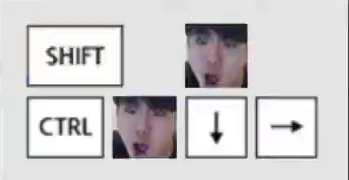

key string at 755.2000000000021 is 111000


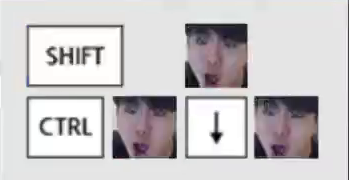

key string at 755.3000000000021 is 101000


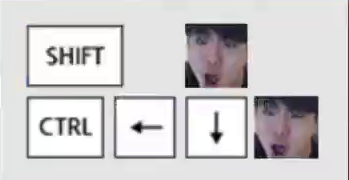

key string at 755.4000000000021 is 101000


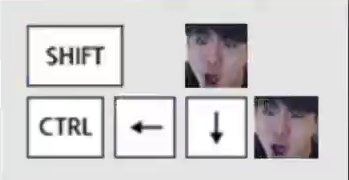

key string at 755.5000000000022 is 101000


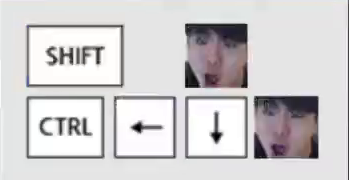

key string at 755.6000000000022 is 111000


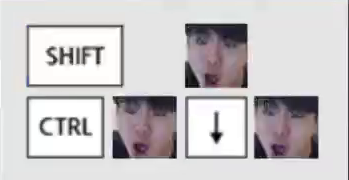

key string at 755.7000000000022 is 110000


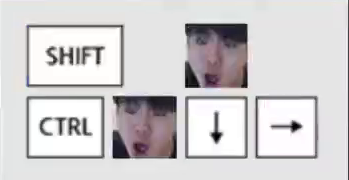

key string at 755.8000000000022 is 110000


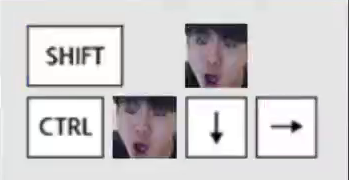

key string at 755.9000000000023 is 110000


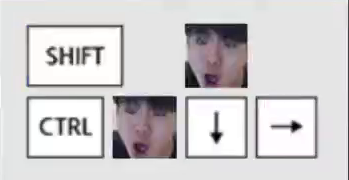

key string at 756.0000000000023 is 111000


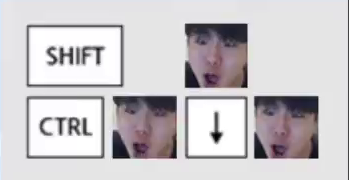

key string at 756.1000000000023 is 101000


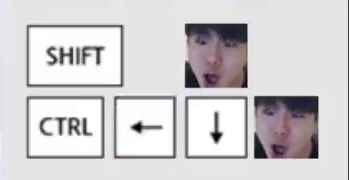

key string at 756.2000000000023 is 100000


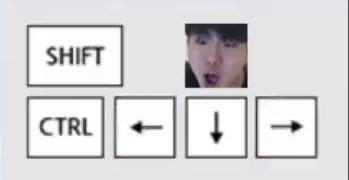

key string at 756.3000000000023 is 100000


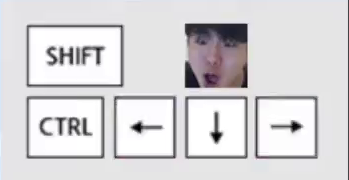

key string at 756.4000000000024 is 100000


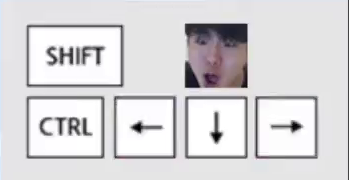

key string at 756.5000000000024 is 101000


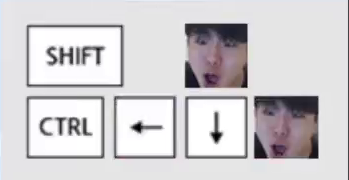

key string at 756.6000000000024 is 101000


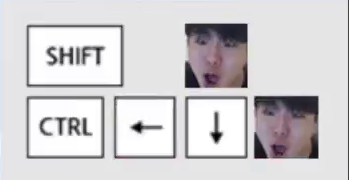

key string at 756.7000000000024 is 100000


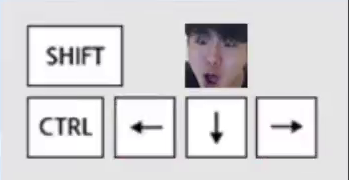

key string at 756.8000000000025 is 101000


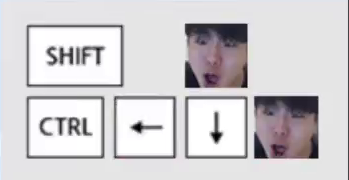

key string at 756.9000000000025 is 101000


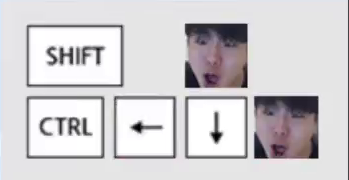

key string at 757.0000000000025 is 101000


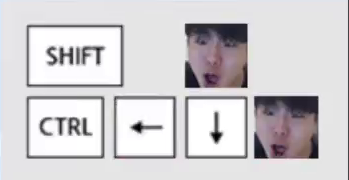

key string at 757.1000000000025 is 101010


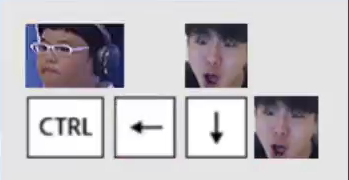

key string at 757.2000000000025 is 101010


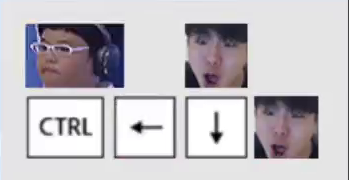

key string at 757.3000000000026 is 101010


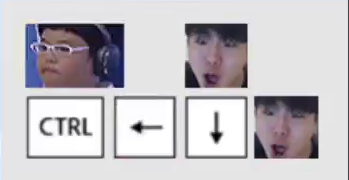

key string at 757.4000000000026 is 101010


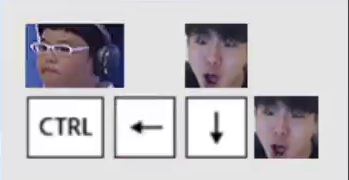

key string at 757.5000000000026 is 101010


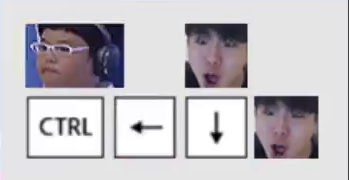

key string at 757.6000000000026 is 101010


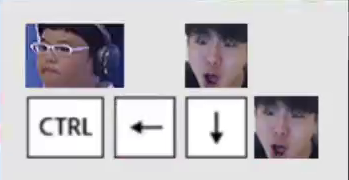

key string at 757.7000000000027 is 101010


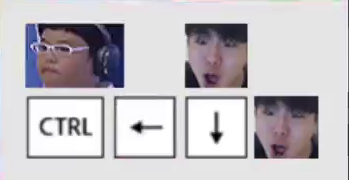

key string at 757.8000000000027 is 101010


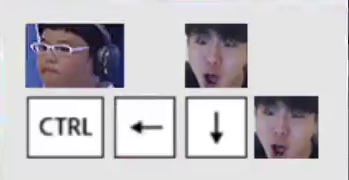

key string at 757.9000000000027 is 101010


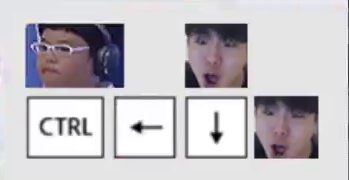

key string at 758.0000000000027 is 110000


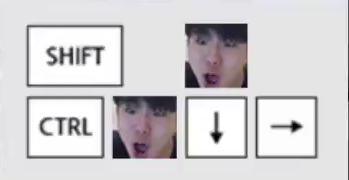

key string at 758.1000000000028 is 110000


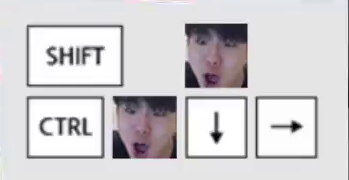

key string at 758.2000000000028 is 110000


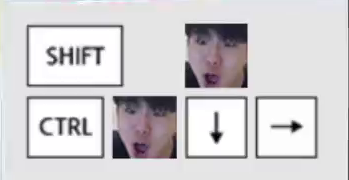

key string at 758.3000000000028 is 110000


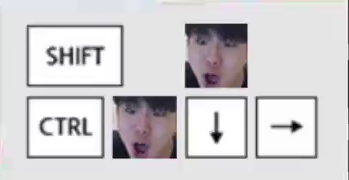

key string at 758.4000000000028 is 110000


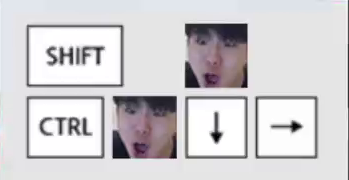

key string at 758.5000000000028 is 110000


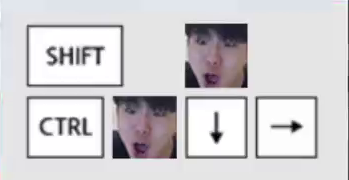

key string at 758.6000000000029 is 010000


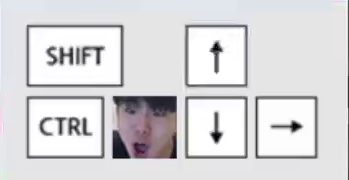

key string at 758.7000000000029 is 110000


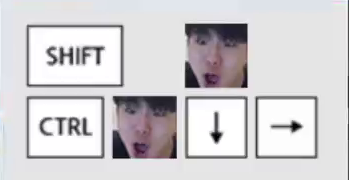

key string at 758.8000000000029 is 110000


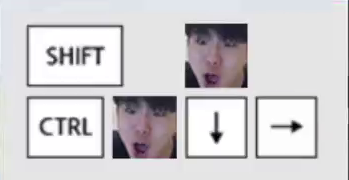

key string at 758.9000000000029 is 101000


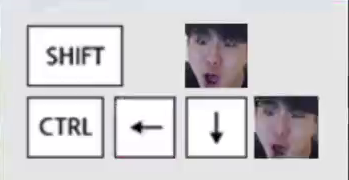

key string at 759.000000000003 is 101000


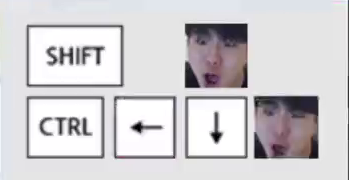

key string at 759.100000000003 is 101000


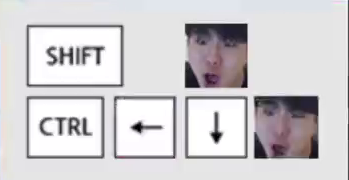

key string at 759.200000000003 is 101000


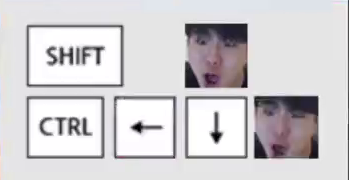

key string at 759.300000000003 is 110000


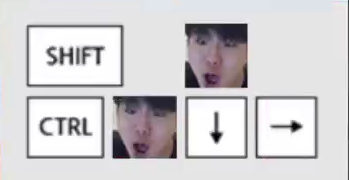

key string at 759.400000000003 is 110000


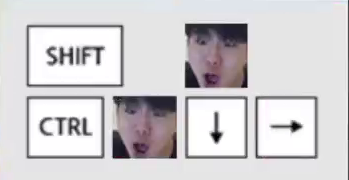

key string at 759.5000000000031 is 110000


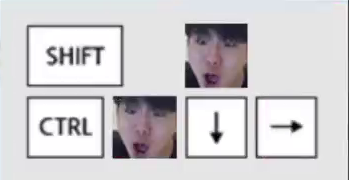

key string at 759.6000000000031 is 110000


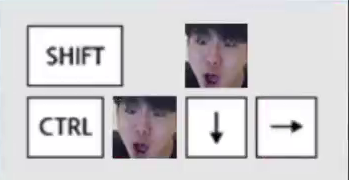

key string at 759.7000000000031 is 110000


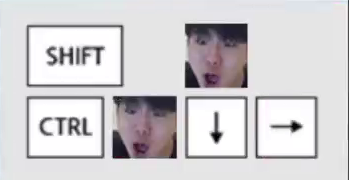

key string at 759.8000000000031 is 101000


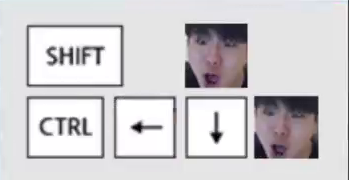

key string at 759.9000000000032 is 101000


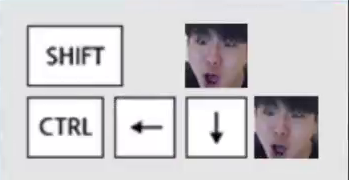

key string at 760.0000000000032 is 101000


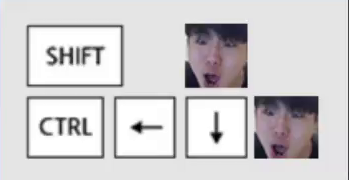

key string at 760.1000000000032 is 101000


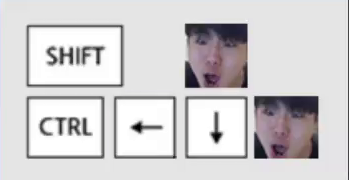

key string at 760.2000000000032 is 110000


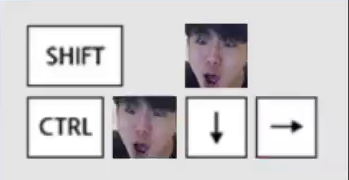

key string at 760.3000000000033 is 110000


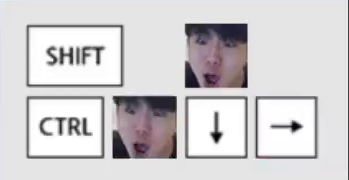

key string at 760.4000000000033 is 110000


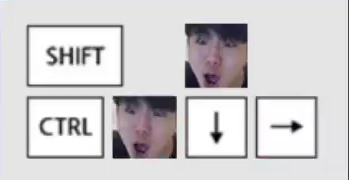

key string at 760.5000000000033 is 110000


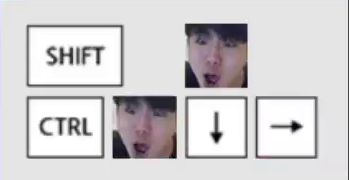

key string at 760.6000000000033 is 110000


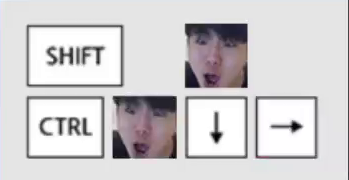

key string at 760.7000000000033 is 110000


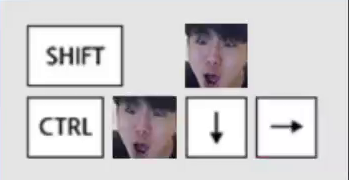

key string at 760.8000000000034 is 110000


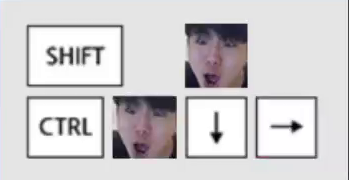

key string at 760.9000000000034 is 110010


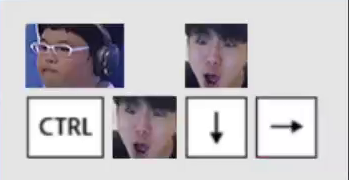

key string at 761.0000000000034 is 110010


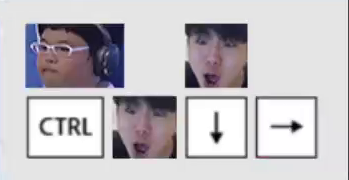

key string at 761.1000000000034 is 110010


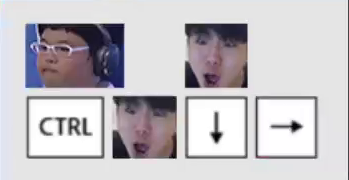

key string at 761.2000000000035 is 110010


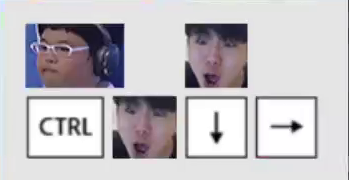

key string at 761.3000000000035 is 110010


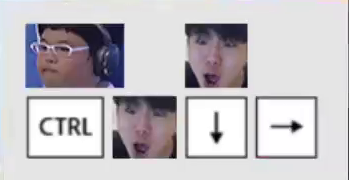

key string at 761.4000000000035 is 110010


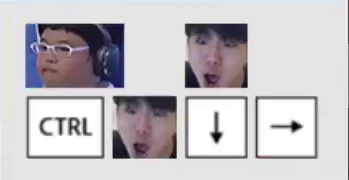

key string at 761.5000000000035 is 110010


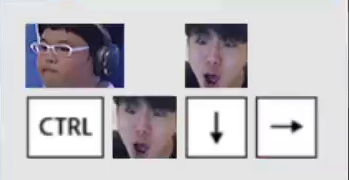

key string at 761.6000000000035 is 110010


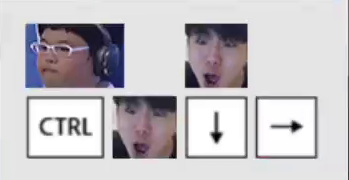

key string at 761.7000000000036 is 110010


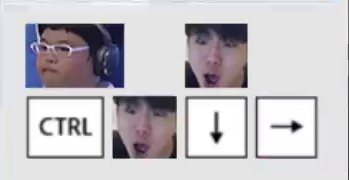

key string at 761.8000000000036 is 100000


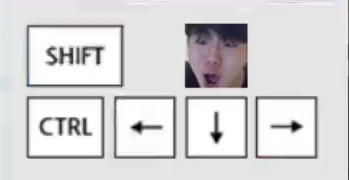

key string at 761.9000000000036 is 101000


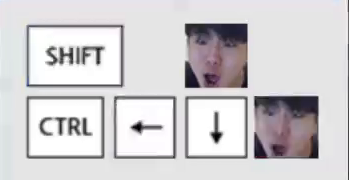

key string at 762.0000000000036 is 101000


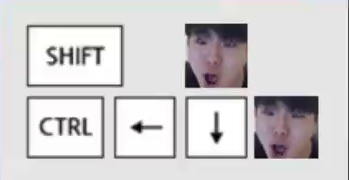

key string at 762.1000000000037 is 101000


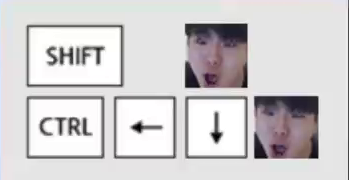

key string at 762.2000000000037 is 101000


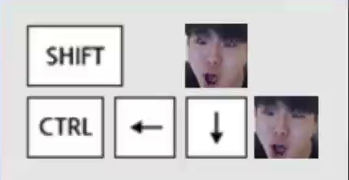

key string at 762.3000000000037 is 101000


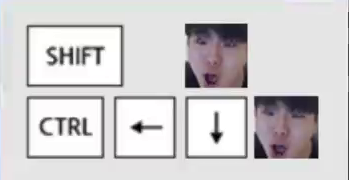

key string at 762.4000000000037 is 001000


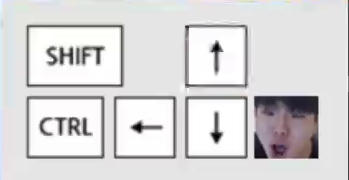

key string at 762.5000000000038 is 101000


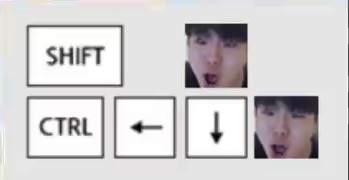

key string at 762.6000000000038 is 101000


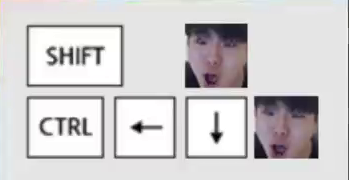

key string at 762.7000000000038 is 110000


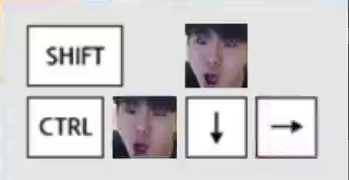

key string at 762.8000000000038 is 110000


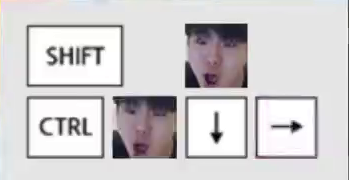

key string at 762.9000000000038 is 101000


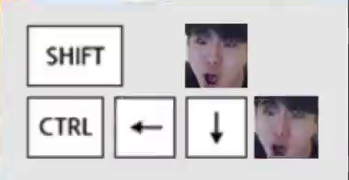

key string at 763.0000000000039 is 101000


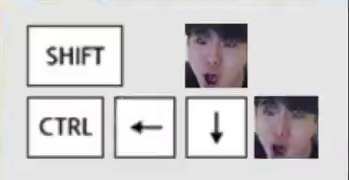

key string at 763.1000000000039 is 100000


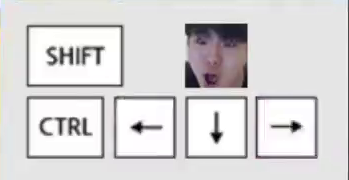

key string at 763.2000000000039 is 101000


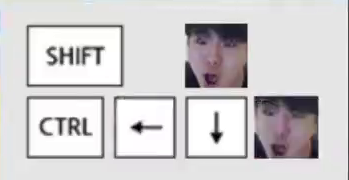

key string at 763.3000000000039 is 101000


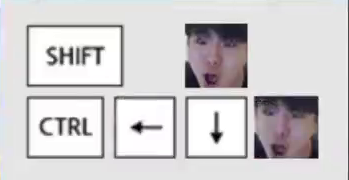

key string at 763.400000000004 is 101000


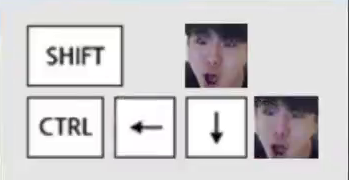

key string at 763.500000000004 is 101000


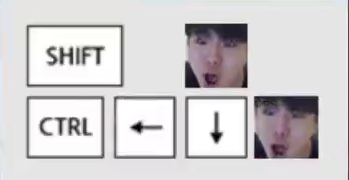

key string at 763.600000000004 is 101000


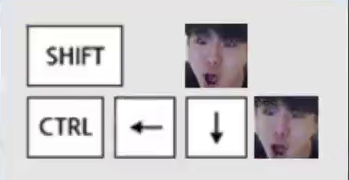

key string at 763.700000000004 is 101010


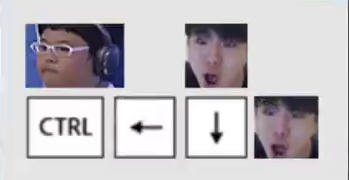

key string at 763.800000000004 is 101010


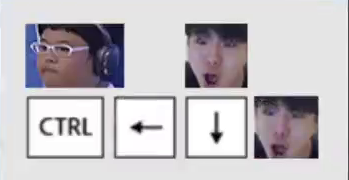

key string at 763.9000000000041 is 101010


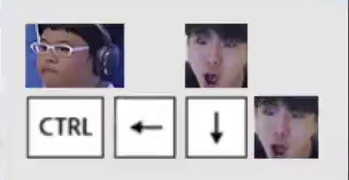

key string at 764.0000000000041 is 101010


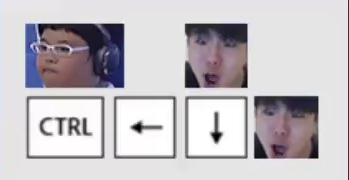

key string at 764.1000000000041 is 101010


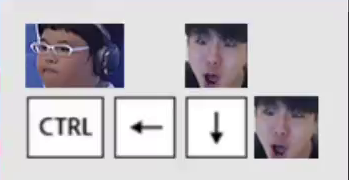

key string at 764.2000000000041 is 101010


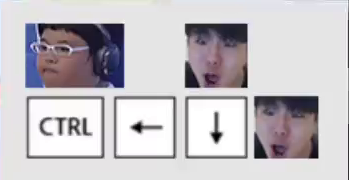

key string at 764.3000000000042 is 101010


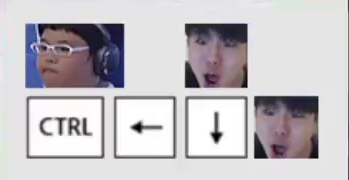

key string at 764.4000000000042 is 101010


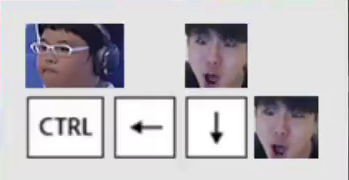

key string at 764.5000000000042 is 110000


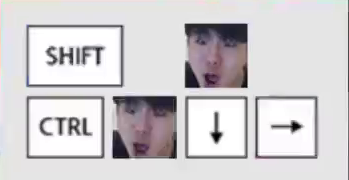

key string at 764.6000000000042 is 110000


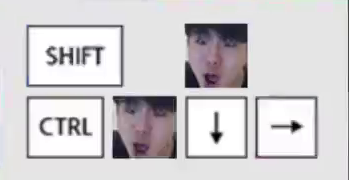

key string at 764.7000000000043 is 110000


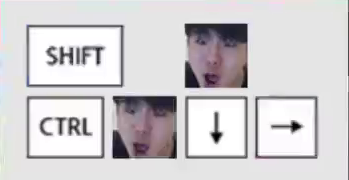

key string at 764.8000000000043 is 110000


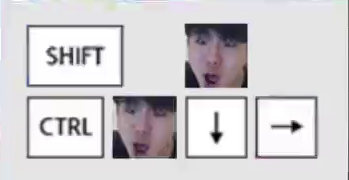

key string at 764.9000000000043 is 110000


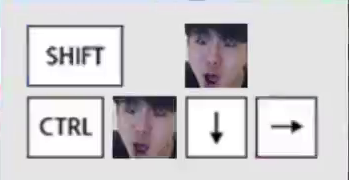

key string at 765.0000000000043 is 110000


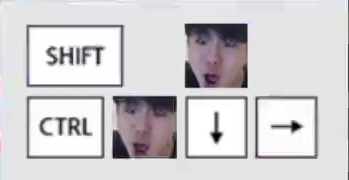

key string at 765.1000000000043 is 110000


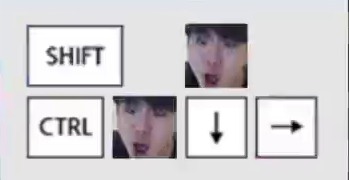

key string at 765.2000000000044 is 110000


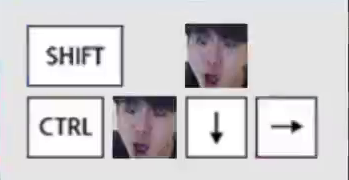

key string at 765.3000000000044 is 101000


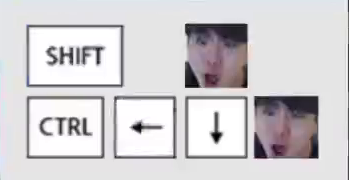

key string at 765.4000000000044 is 111000


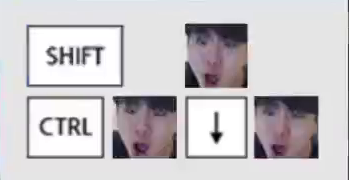

key string at 765.5000000000044 is 110000


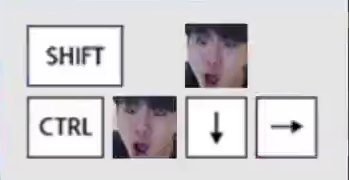

key string at 765.6000000000045 is 100000


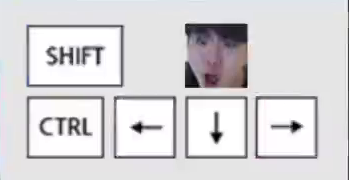

key string at 765.7000000000045 is 100000


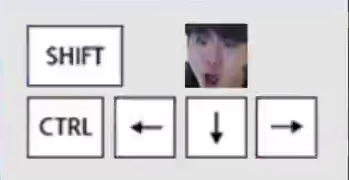

key string at 765.8000000000045 is 100000


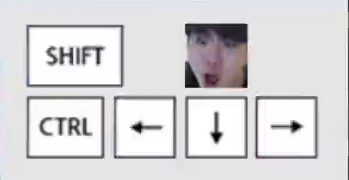

key string at 765.9000000000045 is 100000


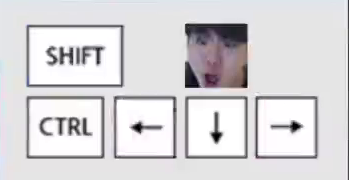

key string at 766.0000000000045 is 110000


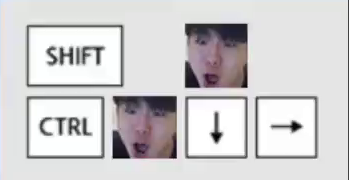

key string at 766.1000000000046 is 110000


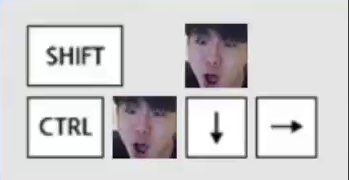

key string at 766.2000000000046 is 110000


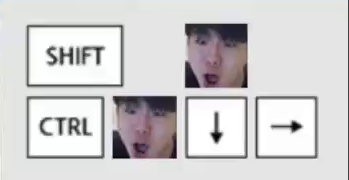

key string at 766.3000000000046 is 110000


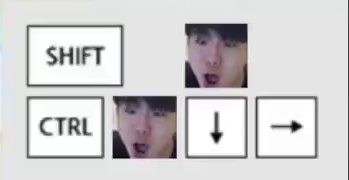

key string at 766.4000000000046 is 110010


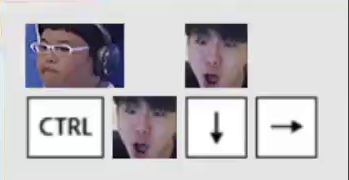

key string at 766.5000000000047 is 110010


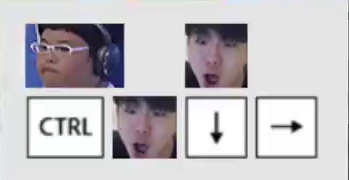

key string at 766.6000000000047 is 110010


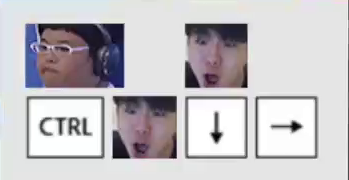

key string at 766.7000000000047 is 110010


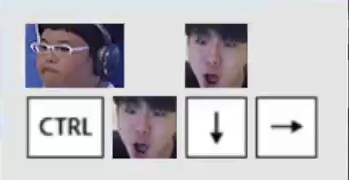

key string at 766.8000000000047 is 110010


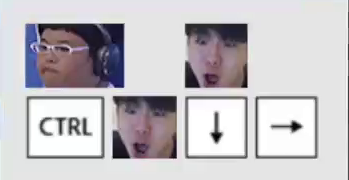

key string at 766.9000000000048 is 110010


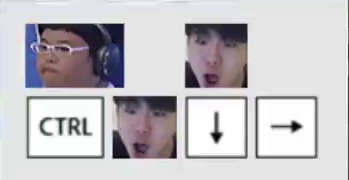

In [23]:
for t in tqdm(np.arange(start_sec, end_sec, interval)):
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret,frame = cap.read()

    if not ret:
        print("영상 시간 초과 또는 영상 관련 오류")
        
    # 계기판 속도
    speed = gauge_speed(frame)
    # 부스터 ON/OFF 여부
    boost = boost_v1(frame)
    # 드래프트 ON/OFF 여부
    draft = draft_v1(frame)
    # 부스터 충전 게이지
    boost_percent = boost_range(frame)
    # 부스터 아이템 보유 여부
    boost_item = check_boost(boost_img_list,frame,boost_slot_size)
    # 순위 추출
    rank = getRank(frame)

    # 키 입력 추출
    key_array = [is_pushed(frame[index[1]:index[1]+key_size,index[0]:index[0]+key_size]) for index in key_pos]

    # 추출된 키 입력을 string type 변경
    keystring = ''.join(str(key) for key in key_array)
    print(f"key string at {t} is {keystring}")

    # 게임 화면만 저장
    cropped_img = frame[:1080,:1440]
    minimap_img = frame[401:637, 1164:1416]

    # 이미지 파일에서 키 뷰어부분 마스킹
    cv2_imshow(frame[1080-key_viewer_size[1]:1080,1440-key_viewer_size[0]:1440])
    frame[1080-key_viewer_size[1]:1080,1440-key_viewer_size[0]:1440] = 0

    # 이미지 저장 경로
    imgpath1 = os.path.join(capdir1, f"t{t}.jpg")
    imgpath2 = os.path.join(capdir2, f"t{t}.jpg")
    
    # 이미지 저장
    cv2.imwrite(os.path.join(drivepath, imgpath1), cropped_img)
    cv2.imwrite(os.path.join(drivepath, imgpath2), minimap_img)

    # csv 파일 저장 (전체, 미니맵, 속도, 부스터, 드래프트, 부스터 게이지, 아이템, 순위, 입력 키)
    wrcsv.writerow([prevpath, prevminimap, prevspeed, prevboost, prevdraft, prevboost_percent, previtem, prevrank, keystring])
    
    t += interval
    prevpath = imgpath1
    prevminimap = imgpath2
    prevspeed = speed
    prevboost = boost
    prevdraft = draft
    prevboost_percent = boost_percent
    prevrank = rank
    previtem = boost_item

In [24]:
cap.release()
fcsv.close()